

## A (superficial) introduction to Decision trees (or)

### You too can predict the future using entropy 😬
  
&nbsp;
&nbsp;


      Aditya Godbole, Oneirix Labs


---
## Some basics
<figure>
    <img src="ML_model_types.png" width="600px"/>
    <figcaption>Types of ML models</figcaption>
 </figure>

## Development cycle of a model

<img src="ML_train_test.png" width="600px"/>

In [1]:
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn import preprocessing
from IPython.display import display

---
## Decision trees

### The problem statement

Lets say we have data in the following tabular format of *past* data indicating weather conditions and whether a game was played on that day or not

In [2]:
inp = pd.read_csv("data.csv")
inp

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


And we want to train a tree based model such that

- Given a new tulple (row) with values for the above columns
- We want to predict whether or not there will be any play

The model will be a tree of questions based on the features (columns) somewhat similar to this one

<img src="eg1.png" width="600px"/>

### Considerations for building the tree model

- For each node, which feature should we ask the question on?

Intuitively, a shorter tree is a better model and will generalise better.
(We will see a more formal proof of this later).

### So we want to prioritise those features which have "more information"
### A feature carries more information if it separates the target variable better

---
## Entropy

From information theory, we have concept called **entropy**

- which tells how homogenous a particular data set is
- entropy is higher if the data-set is more evenly spread
- entropy is lower if it is less evenly spread

Consider a feature which has only two categories, like `Windy`. We will call these categories $\oplus$ and $\ominus$

Then entropy of the feature

$$
Entropy(S) = -p_\oplus log_2 p_\oplus -p_\ominus log_2 p_\ominus
$$


In [3]:
windy = inp['windy']
pos = len(windy[windy == True])
neg = len(windy[windy == False])
tot = len(windy)
print(f"{pos=}, {neg=}, {tot=}")
e_windy = -(pos/tot)*np.log2(pos/tot) -(neg/tot)*np.log2(neg/tot)
print(f"{e_windy=}")

pos=6, neg=8, tot=14
e_windy=0.9852281360342515


In [4]:
def entropy(vals):
    counts = vals.value_counts(normalize=True, sort=False)
    return (-counts*np.log2(counts)).sum()
print(f"{entropy(windy)=}")
print(f"{entropy(inp['play'])=}")

entropy(windy)=0.9852281360342515
entropy(inp['play'])=0.9402859586706311


### The entropy plot of a binary value feature looks like

<img src="entr_plot.svg" width="400px"/>

---
### Entropy wrt target (relative entropy)

$$
Entropy_{play}(windy) = p_{windy(\oplus)}(Entropy_{play} \forall windy \in \oplus) + p_{windy(\ominus)}(Entropy_{play} \forall windy \in \ominus)
$$

In [5]:
play_windy_true = inp.loc[inp['windy'] == True, 'play']
play_windy_false = inp.loc[inp['windy'] == False, 'play']
eplay_windy = (entropy(play_windy_true)*len(play_windy_true)/len(inp) + entropy(play_windy_false)*len(play_windy_false)/len(inp))
eplay_windy

0.8921589282623617

In [6]:
def rel_entropy(data, attr, target):
    return data.groupby(attr).apply(lambda x: entropy(x[target])*len(x)/len(data)).sum()
rel_entropy(inp, 'windy', 'play')

0.8921589282623617

## Information gain

$$
Gain(Play, Windy) = Entropy_{play} - Entropy_{play}(windy)
$$

### When we split the data based on values of Windy
- What is the total entropy of Play for each node
- What is the sum of totals on entropy of each node
- How much lesser is it compared to the entropy prior to the split?
  

  
<img src="eg2.png" width="700px"/>


In [7]:
play = inp['play']
gain_windy = entropy(play) - rel_entropy(inp, 'windy', 'play')
print(f"{gain_windy=}")
gain_humidity = entropy(play) - rel_entropy(inp, 'humidity', 'play')
print(f"{gain_humidity=}")

gain_windy=0.04812703040826949
gain_humidity=0.15183550136234159


---
### To select the feature to split on for a node

1. Calculate relative entropies of target feature wrt to each input feature
2. Select the feature with maximum information gain


---
### Non discrete input features

- Non discrete features are handled by
 - Sorting the data by the feature values
 - Find values for which target variable changes
 - Define a category boundary at the midpoint of the change
 
Eg.

||||||||
|---|---|---|---|---|---|---|
|Temperature|40|48|60|72|80|90|
|Play|No|No|Yes|Yes|Yes|No|

Switches occur at Temperature = 60 and 90  

Category are therefore computed at $Temp = (48+60)/2$ and $Temp = (80+90)/2$


In [8]:
inp_l = inp.apply(preprocessing.LabelEncoder().fit_transform)
inp_l

,outlook,temp,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [9]:
Y = inp_l['play']
X = inp_l.drop(columns=['play'])
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

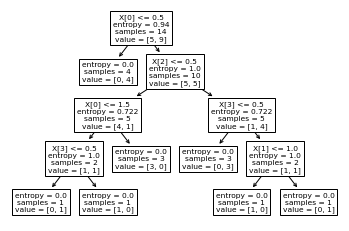

In [10]:
plt = tree.plot_tree(clf)

---
### Uses of decision tree classifiers

1. Building supervised classification models
2. Deriving rules for unsupervised classification models

---
## Decision tree regression

- For classification: maximise information gain
- For regression: minimise standard deviation

---
## Overfitting

Overfitting is a standard tradeoff in learning algorithms

- Tree can fit all seen data
- What about unseen data?
  - There is a tradeoff between accuracy of fitting training data vs accuracy of predicting unseen data
- Smaller trees are more generalised